https://github.com/josuebatista/PyTorchOCR/blob/main/PyTorch_OCR.ipynb

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image



In [2]:
data = torchvision.datasets.ImageFolder(
    root='./EnglishFnt/English/Fnt',
    transform=transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

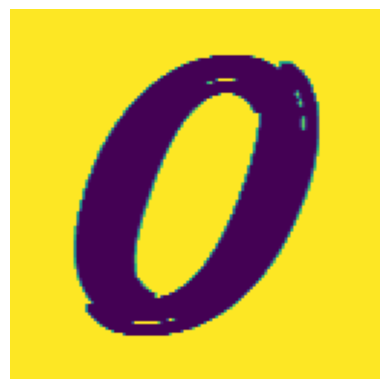

torch.Size([1, 1, 48, 48])


In [3]:
image_path = 'EnglishFnt/English/Fnt/Sample001/img001-00012.png'
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

preprocess = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
preprocessed_image = preprocess(image)
image_tensor = preprocessed_image.unsqueeze(0)

print(image_tensor.shape)

In [4]:
def load_split(dataset, batch_size, test_split=0.3, random_seed=42):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    split = int(np.floor(test_split * dataset_size))
    train_indices, test_indices = indices[split:], indices[:split]

    testset_size = len(test_indices)
    indices = list(range(testset_size))
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    split = int(np.floor(0.5 * testset_size))
    val_indices, test_indices = indices[split:], indices[:split]

    # Creating data samplers:
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    # Creating data loaders:
    train_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=test_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=val_sampler)

    return train_loader, test_loader, val_loader

batch_size = 36
train_loader, test_loader, val_loader = load_split(data, batch_size, test_split=0.3)
print(f"Train size: {len(train_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")

Train size: 62992
Test size: 62992
Validation size: 62992


In [5]:
for batch in train_loader:
    images, labels = batch
    print(images.shape)  # Print the shape of the batch of images
    print(labels.shape)  # Print the shape of the batch of labels
    break  # Print only the first batch

torch.Size([36, 3, 48, 48])
torch.Size([36])


In [6]:
class OCRNet(nn.Module):
    def __init__(self, num_features):
        super(OCRNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(num_features, 62)  # Output has 62 classes instead of 10

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

num_features = 32 * 48 * 48  # Adjust this value based on the actual feature size
model = OCRNet(num_features)

In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [8]:
def train(model, train_loader, optimizer, criterion, num_epochs=10, print_every=100):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_count = 0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_count += 1

            # Print average loss every 'print_every' mini-batches
            if (i+1) % print_every == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Average Loss: {running_loss/running_count:.4f}")
                running_loss = 0.0
                running_count = 0

        # Print loss after each epoch
        epoch_loss = running_loss / len(train_loader)
        print(f"\nEnd of Epoch {epoch+1}/{num_epochs}, Average Epoch Loss: {epoch_loss:.4f}")


In [9]:
train(model, train_loader, optimizer, criterion, num_epochs=20)


Epoch [1/20], Step [100/1225], Average Loss: 3.6353
Epoch [1/20], Step [200/1225], Average Loss: 2.1315
Epoch [1/20], Step [300/1225], Average Loss: 1.7254
Epoch [1/20], Step [400/1225], Average Loss: 1.5510
Epoch [1/20], Step [500/1225], Average Loss: 1.4697
Epoch [1/20], Step [600/1225], Average Loss: 1.3597
Epoch [1/20], Step [700/1225], Average Loss: 1.2711
Epoch [1/20], Step [800/1225], Average Loss: 1.2743
Epoch [1/20], Step [900/1225], Average Loss: 1.2258
Epoch [1/20], Step [1000/1225], Average Loss: 1.2044
Epoch [1/20], Step [1100/1225], Average Loss: 1.1604
Epoch [1/20], Step [1200/1225], Average Loss: 1.1024

End of Epoch 1/20, Average Epoch Loss: 0.0217
Epoch [2/20], Step [100/1225], Average Loss: 1.0469
Epoch [2/20], Step [200/1225], Average Loss: 1.0079
Epoch [2/20], Step [300/1225], Average Loss: 1.0027
Epoch [2/20], Step [400/1225], Average Loss: 1.0097
Epoch [2/20], Step [500/1225], Average Loss: 1.0016
Epoch [2/20], Step [600/1225], Average Loss: 0.9639
Epoch [2/20], 

In [13]:
torch.save(model.state_dict(), 'PyTorch_OCR.pth')

In [14]:
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f'Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

validate(model, val_loader, criterion)

Validation Loss: 0.2429, Validation Accuracy: 93.12%


In [15]:
def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

test(model, test_loader, criterion)

Test Loss: 0.2524, Test Accuracy: 92.90%


Predicted Class: 0, Confidence: 78.16%


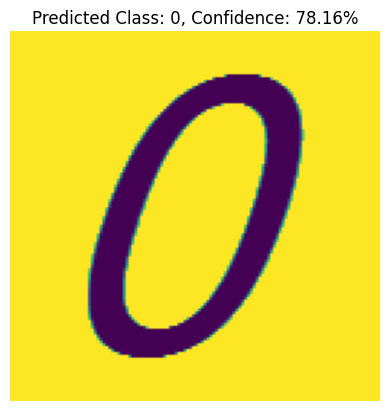

In [22]:

classes = list('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz')

def predict(model, image_path, transform):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB
    image = transform(image).unsqueeze(0)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        predicted_prob, predicted_idx = torch.max(probabilities, 1)
        predicted_class = classes[predicted_idx]

        confidence = predicted_prob.item() * 100  # convert to percentage
        print(f'Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%')

    plt.imshow(Image.open(image_path))
    plt.title(f'Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%')
    plt.axis('off')
    plt.show()

# Specify the path to your image
#image_path = '/content/EnglishFnt/English/Fnt/Sample049/img049-00001.png'
image_path = 'EnglishFnt/English/Fnt/Sample001/img001-00047.png'

predict(model, image_path, preprocess)